In [1]:
__author__ = "Thomas McClave"
# Uses Atchar Sudhyadhom's paper.

import json
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import re

In [2]:
# Open all JSON files and read them into a single dictionary.
with open('dixon/dixon-results.json','r') as dixRes:
    dix_res = json.loads(dixRes.read())
with open('zte/zte-results.json','r') as zteRes:
    zte_res = json.loads(zteRes.read())
with open('ct/ct-results.json','r') as ctRes:
    ct_res = json.loads(ctRes.read())
# with open('chem/chem-results.json','r') as chemRes:
#     chem_res = json.loads(chemRes.read())

containers = {} # Will house all of the information for all containers in a centralized dictionary.
for roi in dix_res:
    containers[roi] = {}
    containers[roi]['label'] = dix_res[roi]['label']
    containers[roi]['dixon'] = dix_res[roi]['data']
    containers[roi]['zte'] = zte_res[roi]['data']
    containers[roi]['ct'] = ct_res[roi]['data']
#     containers[roi]['chem'] = chem_res[roi]['data']

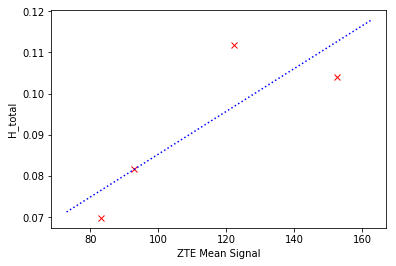

In [3]:
# UCSF Stoichiometric Calibration Curve data:
HU_refs_below = np.array([-1000, -200, -120, -20])
HU_refs_above = np.array([35, 100, 140, 4500])
psrel_refs_below = np.array([0.0, 0.7985, 0.9476, 1.0125])
psrel_refs_above = np.array([1.0330, 1.0979, 1.0964, 3.1221])

fit_stoich_below = np.polyfit(HU_refs_below, psrel_refs_below, 1)
fit_fn_stoich_below = np.poly1d(fit_stoich_below)
fit_stoich_above = np.polyfit(HU_refs_above, psrel_refs_above, 1)
fit_fn_stoich_above = np.poly1d(fit_stoich_above)


# Create ZTE calibration curve that uses (Signal_zte)/(physical density):
calibration_containers = ["W01.1", "A02.1", "A03.1", "A04.1"]
pd_over_rhoPhysical = np.array([])
for cc in calibration_containers:
    pd = containers[cc]['zte']['ZTE Mean Signal']
    rhoPhysical = containers[cc]['ct']['CT fit physical density']
    pd_over_rhoPhysical = np.append(pd_over_rhoPhysical, float(pd/rhoPhysical))
            
H_refs = np.array([
    0.111898344, # Water (W01.1)
    0.081688083, # Acetone (A02.1)
    0.104127575, # Isopropyl Alcohol (A03.1)
    0.069864914, # Propargyl Alcohol (A04.1)
])

fit = np.polyfit(pd_over_rhoPhysical, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.plot(pd_over_rhoPhysical, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pd_over_rhoPhysical)-10, max(pd_over_rhoPhysical)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.xlabel('ZTE Mean Signal')
plt.ylabel('H_total')
plt.show()

In [4]:
def SPR_UC(pe_water, I_m):
    # Returns proton stopping power ratio using UC model.
    beta = 0.454363  # Proton w/ 115 MeV kinetic energy:
    e_m_E = 510998.9  # Electron rest mass energy (mc^2) in eV.
    I_water = 75.3 # (eV), from chemical composition!
    numerator = np.log( (2*e_m_E*beta**2) / (I_m*(1-beta**2)) ) - beta**2
    denominator = np.log( (2*e_m_E*beta**2) / (I_water*(1-beta**2)) ) - beta**2
    return float(pe_water*numerator/denominator)

# def SPR_CHEM

def calc_I_m(h_tot, w_H20, w_HA, CT_num):
    # Returns I_m (ionization potential for given material).
    A = 93.23 # eV
    B = -3.47 # eV
    I_water = 75.3 # (eV), from chemical composition.
    I_HA = 156.2 # (eV), from chemical composition.
    h_org_vox = calc_h_org_vox(h_tot, w_H20, w_HA, CT_num)
    if (CT_num < 1200): # Calculate assuming soft tissue.
        I_m_log = w_H20*np.log(I_water) + (1-w_H20)*(np.log(A) + B*h_org_vox)
    else: # Calculate assuming bone as well.
#         I_m_log = w_H20*np.log(I_water) + (1-w_H20)*(np.log(A) + B*h_org_vox)
        I_m_log = w_H20*np.log(I_water) + (1-w_H20-w_HA)*(np.log(A) + B*h_org_vox) + w_HA*np.log(I_HA)
    return np.exp(I_m_log)

def calc_h_org_vox(h_tot, w_H20, w_HA, CT_num):
    # Returns h_org_vox (actually per ROI, currently).
    h_H20 = 0.111898344
    h_HA = 0.002
    if (CT_num < 1200): # Calculate assuming soft tissue.
        return (h_tot - w_H20*h_H20) / (1 - w_H20)
    else: # Calculate assuming bone as well.
        return (h_tot - w_H20*h_H20 - w_HA*h_HA) / (1 - w_H20 - w_HA)

def calc_h_tot(roi):
    # Returns h_tot for this particular roi.
    pd = containers[roi]['zte']['ZTE Mean Signal']
    rhoPhysical = containers[roi]['ct']['CT fit physical density']
    return fit_fn(pd / rhoPhysical)

In [5]:
# Calculate SPRs for all containers:
cid_re = re.compile('[A-Z][0-9]{2}\.?[0-9]?')
results = {}

HU_vals = []
spr_vals = []

for roi in containers:
#     if ('B' not in roi): # We're not considering any bone this time!
    h_tot = calc_h_tot(roi)
    w_H20 = containers[roi]['dixon']['Dixon Water Signal'] / containers['W01.1']['dixon']['Dixon Water Signal']        
    rhoPhysical = containers[roi]['ct']['CT fit physical density']
    CT_num = containers[roi]['ct']['CT Mean CT number']
    w_HA = containers[roi]['ct']['w_HA']
    I_m = calc_I_m(h_tot, w_H20, w_HA, CT_num)
    pe_water = containers[roi]['ct']['CT fit relative electron density']

    SPR_val_UC = SPR_UC(pe_water, I_m)
    containers[roi]['SPR_UC'] = SPR_val_UC

    HU_vals += [containers[roi]['ct']['CT Mean HU value']]
    spr_vals += [SPR_val_UC]

    cid = cid_re.search(containers[roi]['label']).group()
    results[cid] = {
        'label' : containers[roi]['label'],
        'data' : {
            'SPR UC Value' : SPR_val_UC
        }
    }

    
# # Write in chemical composition values:
# SPR_chem_comp = np.zeros(len([roi for roi in containers if 'B' not in roi]))
# SPR_chem_comp_HU = np.zeros(len(SPR_chem_comp))
# I_isopropyl_alcohol=62.8803
# pe_water_isoprop=0.818858
# SPR_chem_comp_HU[1] = containers['A03.1']['ct']['CT Mean HU value']
# SPR_chem_comp[1] = SPR_UC(pe_water_isoprop, I_isopropyl_alcohol) # Isopropyl Alcohol

# I_acetone=66.1406
# pe_water_acetone=0.77818
# SPR_chem_comp_HU[0] = containers['A02.1']['ct']['CT Mean HU value']
# SPR_chem_comp[0] = SPR_UC(pe_water_acetone, I_acetone) # Acetone


# # Calculation for liver:
# curr_liver_index = 3
# for roi in containers:
#     if ("N0" in roi or "I0" in roi or "L0" in roi):
#         p_m_liver = containers[roi]['ct']['CT fit physical density']
#         pe_water_liver = p_m_liver*0.548778005/(10/18.0152)
#         I_liver=74.49449405
#         SPR_liver_true=SPR_UC(pe_water_liver, I_liver)
#         SPR_chem_comp[curr_liver_index] = SPR_liver_true
#         SPR_chem_comp_HU[curr_liver_index] = containers[roi]['ct']['CT Mean HU value']
#         curr_liver_index += 1


with open('spr-results.json','w') as jout:
    jout.write(json.dumps(results, indent=4, sort_keys=True))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
# Create output Table:
print('SPR (MR+CT): ', '\t| SPR (CT): ', '\t| SPR (CHEM): ', '\t| Label:')
for roi in containers:
    SPR_val_UC = round(containers[roi]['SPR_UC'], 6)
#         SPR_CHEM = format(SPR_chem_comp[i], '.6f')
    label = containers[roi]['label']
    HU_val = containers[roi]['ct']['CT Mean HU value']
    if (HU_val < 0):
        SPR_CT = round(fit_fn_stoich_below(HU_val), 6)
    else:
        SPR_CT = round(fit_fn_stoich_above(HU_val), 6)
    print('', SPR_val_UC, '\t| ', SPR_CT, '\t| ', label)
#         print('', SPR_val_UC, '\t| ', SPR_CT, '\t| ', SPR_CHEM, '\t| ', label)

SPR (MR+CT):  	| SPR (CT):  	| SPR (CHEM):  	| Label:
 0.840716 	|  0.817155 	|  7: (A02.1) (A1) Acetone
 0.904335 	|  0.871332 	|  1: (A03.1) (IA1) Isopropyl Alcohol
 1.022753 	|  1.013325 	|  8: (A04.1) (PA1) Propargyl Alcohol
 1.126922 	|  1.149188 	|  2: (B01.1) (BMP1) Bone Meal Powder
 1.758644 	|  1.911338 	|  14: (B02.1) (BB1) Bone Block, Glue, in Air
 1.648228 	|  1.77855 	|  5: (B02.2) (BB2) Bone Block, No Glue, in Air
 1.727106 	|  1.870905 	|  3: (B02.3) (BB3) Bone Block, Glue, in Water
 1.736175 	|  1.877764 	|  15: (B02.4) (BB4) Bone Block, No Glue, in Water
 1.097548 	|  1.093228 	|  12: (I01.1) (I1) Intact Liver (Relative), prep: cut and "stuff"
 1.09439 	|  1.089306 	|  17: (I01.2) (I2) Intact Liver (Relative), prep: cut and "stuff"
 1.097778 	|  1.093474 	|  10: (I01.3) (I3) Intact Liver (Relative), prep: cut and "stuff"
 1.028096 	|  1.013188 	|  16: (L01.1) (LS1(A)) Liver Stability, in Air
 1.042432 	|  1.028516 	|  9: (L01.2) (LS2(B)) Liver Stability, Vacuum
 1.0952

<Figure size 1080x360 with 0 Axes>

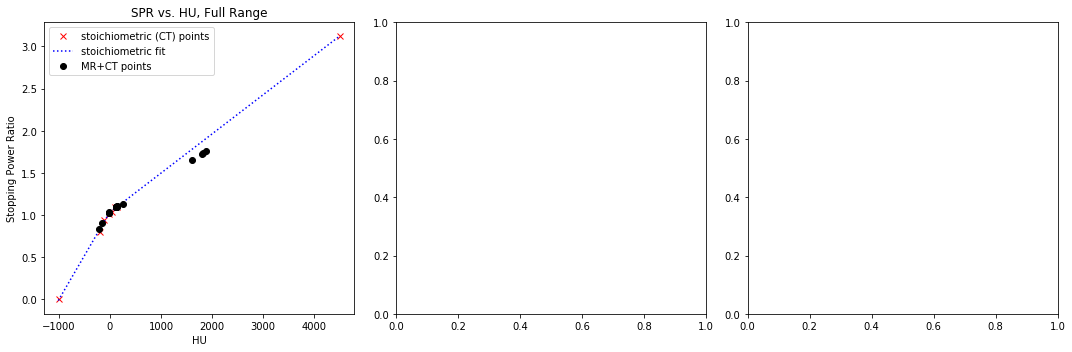

In [7]:
# Plot fits and results:
plt.figure(figsize=(15.0, 5.0))
fig, ax = plt.subplots(1, 3, figsize=(15.0, 5.0))

# SPR_chem_comp_plot = copy(SPR_chem_comp)
# SPR_chem_comp_HU_plot = copy(SPR_chem_comp_HU)

# for j in range(len(SPR_chem_comp_plot)-1, -1, -1):
#     if (SPR_chem_comp_plot[j] < 0.001):
#         SPR_chem_comp_plot = np.delete(SPR_chem_comp_plot, j)
#         SPR_chem_comp_HU_plot = np.delete(SPR_chem_comp_HU_plot, j)
        
# Plot full range:
ai = ax[0]
ai.plot(HU_refs_below, psrel_refs_below, 'rx', label='stoichiometric (CT) points')
ai.plot(HU_refs_above, psrel_refs_above, 'rx')

HU_sig_below = np.linspace(min(HU_refs_below)-10, 0, 10)
ai.plot(HU_sig_below, fit_fn_stoich_below(HU_sig_below), 'b:', label='stoichiometric fit')
HU_sig_above = np.linspace(0, max(HU_refs_above)+10, 10)
ai.plot(HU_sig_above, fit_fn_stoich_above(HU_sig_above), 'b:')

ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
# ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')

ai.set_title('SPR vs. HU, Full Range')
ai.set_xlabel('HU')
ai.set_ylabel('Stopping Power Ratio')
# rect = plt.Rectangle( (min(HU_vals)-100, 0.70) , max(HU_vals)+10 - min(HU_vals)+210 , 1.14-0.65, fill=False, linestyle = 'dashed')
# ai.add_patch(rect)
ai.legend()


# # Plot close-up of range:
# ai = ax[1]
# ai.plot(HU_refs_below, psrel_refs_below, 'rx', label='stoichiometric (CT) points')
# ai.plot(HU_refs_above, psrel_refs_above, 'rx')

# HU_sig_below = np.linspace(min(HU_refs_below)-10, 0, 10)
# ai.plot(HU_sig_below, fit_fn_stoich_below(HU_sig_below), 'b:', label='stoichiometric fit')
# HU_sig_above = np.linspace(0, max(HU_refs_above)+10, 10)
# ai.plot(HU_sig_above, fit_fn_stoich_above(HU_sig_above), 'b:')

# ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
# # ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')
# ai.set_title('SPR vs. HU, Close-up')
# ai.set_xlabel('HU')
# ai.set_ylabel('Stopping Power Ratio')
# ai.set_xlim(min(HU_vals)-10, max(HU_vals)+10)
# ai.set_ylim(0.78, 1.14)
# ai.legend()


# # Plot without outliers:
# HU_refs_stripped_below = [ref for ref in HU_refs_below if (ref > -300 and ref < 3000)]
# HU_refs_stripped_above = [ref for ref in HU_refs_above if (ref > -300 and ref < 3000)]

# psrel_refs_stripped_below = [ref for ref in psrel_refs_below if (ref > 0.5 and ref < 3)]
# psrel_refs_stripped_above = [ref for ref in psrel_refs_above if (ref > 0.5 and ref < 3)]

# fit_stoich_limited_below = np.polyfit(HU_refs_stripped_below, psrel_refs_stripped_below, 1)
# fit_fn_stoich_limited_below = np.poly1d(fit_stoich_limited_below)
# fit_stoich_limited_above = np.polyfit(HU_refs_stripped_above, psrel_refs_stripped_above, 1)
# fit_fn_stoich_limited_above = np.poly1d(fit_stoich_limited_above)

# ai = ax[2]
# ai.plot(HU_refs_stripped_below, psrel_refs_stripped_below, 'rx', label='stoichiometric (CT) points')
# ai.plot(HU_refs_stripped_above, psrel_refs_stripped_above, 'rx')

# HU_sig_below = np.linspace(min(HU_refs_stripped_below)-10, 0, 10)
# ai.plot(HU_sig_below, fit_fn_stoich_limited_below(HU_sig_below), 'b:', label='stoichiometric fit')
# HU_sig_above = np.linspace(0, max(HU_refs_stripped_above)+10, 10)
# ai.plot(HU_sig_above, fit_fn_stoich_limited_above(HU_sig_above), 'b:')

# ai.plot(HU_vals, spr_vals, 'ko', label='MR+CT points')
# # ai.plot(SPR_chem_comp_HU_plot, SPR_chem_comp_plot, 'g*', label='Chem_comp points')
# ai.set_title('SPR vs. HU, Disregarding outliers')
# ai.set_xlabel('HU')
# ai.set_ylabel('Stopping Power Ratio')
# ai.legend()


fig.tight_layout()
fig.patch.set_facecolor('#ffffff')
plt.show()

fig.savefig('SPR_vs_HU.png')